
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.15?urlpath=lab/tree/analysis_mwl.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[analysis_mwl.ipynb](../_static/notebooks/analysis_mwl.ipynb) |
[analysis_mwl.py](../_static/notebooks/analysis_mwl.py)
</div>


# Joint modeling, fitting, and serialization


This tutorial illustrates how to perfom a joint modeling and fitting of the Crab Nebula spectrum using different datasets.
We look at the gamma-ray emission from the Crab nebula between 10 GeV and 100 TeV.
The spectral parameters are optimized by combining a 3D analysis of Fermi-LAT data, a ON/OFF spectral analysis of HESS data, and flux points from HAWC.

In this tutorial we are going to use pre-made datasets. We prepared maps of the Crab region as seen by Fermi-LAT using the same event selection than the [3FHL catalog](https://arxiv.org/abs/1702.00664) (7 years of data with energy from 10 GeV to 2 TeV). For the HESS ON/OFF analysis we used two observations from the [first public data release](https://arxiv.org/abs/1810.04516) with a significant signal from energy of about 600 GeV to 10 TeV. These observations have an offset of 0.5° and a zenith angle of 45-48°. The HAWC flux points data are taken from a [recent analysis](https://arxiv.org/pdf/1905.12518.pdf) based on 2.5 years of data with energy between 300 Gev and 300 TeV. 

More details on how to prepare datasets with the high and low level interfaces are available in these tutorials: 

- https://docs.gammapy.org/0.14/notebooks/fermi_lat.html
- https://docs.gammapy.org/dev/notebooks/hess.html
- https://docs.gammapy.org/dev/notebooks/spectrum_analysis.html


In [1]:
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit, Datasets
from gammapy.spectrum import (
    FluxPoints,
    FluxPointsEstimator,
    FluxPointsDataset,
    SpectrumDatasetOnOff,
)
from gammapy.maps import MapAxis
from pathlib import Path

## Data and models files


The datasets serialization produce YAML files listing the datasets and models. In the following cells we show an example containning only the Fermi-LAT dataset and the Crab model. 

Fermi-LAT-3FHL_datasets.yaml:

```yaml
datasets:
- name: Fermi-LAT
  type: MapDataset
  likelihood: cash
  models:
- Crab Nebula
  background: background
  filename: $GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL_data_Fermi-LAT.fits
```

We used as model a point source with a log-parabola spectrum. The initial parameters were taken from the latest Fermi-LAT catalog [4FGL](https://arxiv.org/abs/1902.10045), then we have re-optimized the spectral parameters for our dataset in the 10 GeV - 2 TeV energy range (fixing the source position).

Fermi-LAT-3FHL_models.yaml:

```yaml
components:
- name: Crab Nebula
  type: SkyModel
  spatial:
    type: PointSpatialModel
    frame: icrs
    parameters:
    - name: lon_0
      value: 83.63310241699219
      unit: deg
      min: .nan
      max: .nan
      frozen: true
    - name: lat_0
      value: 22.019899368286133
      unit: deg
      min: -90.0
      max: 90.0
      frozen: true
  spectral:
    type: LogParabolaSpectralModel
    parameters:
    - name: amplitude
      value: 0.3415498620816483
      unit: cm-2 s-1 TeV-1
      min: .nan
      max: .nan
      frozen: false
    - name: reference
      value: 5.054833602905273e-05
      unit: TeV
      min: .nan
      max: .nan
      frozen: true
    - name: alpha
      value: 2.510798031388936
      unit: ''
      min: .nan
      max: .nan
      frozen: false
    - name: beta
      value: -0.022476498188855533
      unit: ''
      min: .nan
      max: .nan
      frozen: false
- name: background
  type: BackgroundModel
  parameters:
  - name: norm
    value: 0.9544383244743555
    unit: ''
    min: 0.0
    max: .nan
    frozen: false
  - name: tilt
    value: 0.0
    unit: ''
    min: .nan
    max: .nan
    frozen: true
  - name: reference
    value: 1.0
    unit: TeV
    min: .nan
    max: .nan
    frozen: true

```

## Reading  different datasets


### Fermi-LAT 3FHL: map dataset for 3D analysis
For now we let's use the datasets serialization only to read the 3D `MapDataset` associated to Fermi-LAT 3FHL data and models.

In [2]:
path = "$GAMMAPY_DATA/fermi-3fhl-crab/Fermi-LAT-3FHL"
filedata = Path(path + "_datasets.yaml")
filemodel = Path(path + "_models.yaml")
datasets = Datasets.read(filedata=filedata, filemodel=filemodel)
dataset_fermi = datasets[0]

We get the Crab model in order to share it with the other datasets

In [3]:
crab_model = dataset_fermi.models["Crab Nebula"]
crab_spec = crab_model.spectral_model
print(crab_spec)

LogParabolaSpectralModel

   name     value    error      unit      min max frozen
--------- ---------- ----- -------------- --- --- ------
amplitude  3.415e-01   nan cm-2 s-1 TeV-1 nan nan  False
reference  5.055e-05   nan            TeV nan nan   True
    alpha  2.511e+00   nan                nan nan  False
     beta -2.248e-02   nan                nan nan  False


### HESS-DL3: 1D ON/OFF dataset for spectral fitting

The ON/OFF datasets can be read from PHA files following the [OGIP standards](https://heasarc.gsfc.nasa.gov/docs/heasarc/ofwg/docs/spectra/ogip_92_007/node5.html).
We read the PHA files from each observation, and compute a stacked dataset for simplicity.
Then the Crab spectral model previously defined is added to the dataset.

In [4]:
datasets = []

for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce()
dataset_hess.name = "HESS"
dataset_hess.models = crab_model

### HAWC: 1D dataset for flux point fitting

The HAWC flux point are taken from https://arxiv.org/pdf/1905.12518.pdf. Then these flux points are read from a pre-made FITS file and passed to a `FluxPointsDataset` together with the source spectral model.


In [5]:
# read flux points from https://arxiv.org/pdf/1905.12518.pdf
filename = "$GAMMAPY_DATA/hawc_crab/HAWC19_flux_points.fits"
flux_points_hawc = FluxPoints.read(filename)
dataset_hawc = FluxPointsDataset(crab_model, flux_points_hawc, name="HAWC")

## Datasets serialization

The `datasets` object contains each dataset previously defined. 
It can be saved on disk as datasets.yaml, models.yaml, and several data files specific to each dataset. Then the `datasets` can be rebuild later from these files.

In [6]:
datasets = Datasets([dataset_fermi, dataset_hess, dataset_hawc])
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)

datasets.write(path=path, prefix="crab_10GeV_100TeV", overwrite=True)
filedata = path / "crab_10GeV_100TeV_datasets.yaml"
filemodel = path / "crab_10GeV_100TeV_models.yaml"
datasets = Datasets.read(filedata=filedata, filemodel=filemodel)

## Joint analysis

We run the fit on the `Datasets` object that include a dataset for each instrument


In [7]:
%%time
fit_joint = Fit(datasets)
results_joint = fit_joint.run()
print(results_joint)
print(results_joint.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 866
	total stat : -14820.65

   name     value     error        unit         min        max    frozen
--------- --------- --------- -------------- ---------- --------- ------
    lon_0 8.363e+01 0.000e+00            deg        nan       nan   True
    lat_0 2.202e+01 0.000e+00            deg -9.000e+01 9.000e+01   True
amplitude 3.721e-03 6.347e-04 cm-2 s-1 TeV-1        nan       nan  False
reference 5.055e-05 0.000e+00            TeV        nan       nan   True
    alpha 1.246e+00 3.935e-02                       nan       nan  False
     beta 6.247e-02 2.178e-03                       nan       nan  False
     norm 9.826e-01 3.029e-01                 0.000e+00       nan  False
     tilt 0.000e+00 0.000e+00                       nan       nan   True
reference 1.000e+00 0.000e+00            TeV        nan       nan   True
CPU times: user 10.6 s, s

Let's display only the parameters of the Crab spectral model

In [8]:
crab_spec = datasets[0].models["Crab Nebula"].spectral_model
crab_spec.parameters.covariance = results_joint.parameters.get_subcovariance(
    crab_spec.parameters
)
print(crab_spec)

LogParabolaSpectralModel

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
amplitude 3.721e-03 6.347e-04 cm-2 s-1 TeV-1 nan nan  False
reference 5.055e-05 0.000e+00            TeV nan nan   True
    alpha 1.246e+00 3.935e-02                nan nan  False
     beta 6.247e-02 2.178e-03                nan nan  False


We can compute flux points for Fermi-LAT and HESS datasets in order plot them together with the HAWC flux point.

In [9]:
# compute Fermi-LAT and HESS flux points
e_edges = MapAxis.from_bounds(
    0.01, 2.0, nbin=6, interp="log", unit="TeV"
).edges

flux_points_fermi = FluxPointsEstimator(
    datasets=[dataset_fermi], e_edges=e_edges, source="Crab Nebula"
).run()


e_edges = MapAxis.from_bounds(1, 15, nbin=6, interp="log", unit="TeV").edges
flux_points_hess = FluxPointsEstimator(
    datasets=[dataset_hess], e_edges=e_edges
).run()

Now, Let's plot the Crab spectrum fitted and the flux points of each instrument.


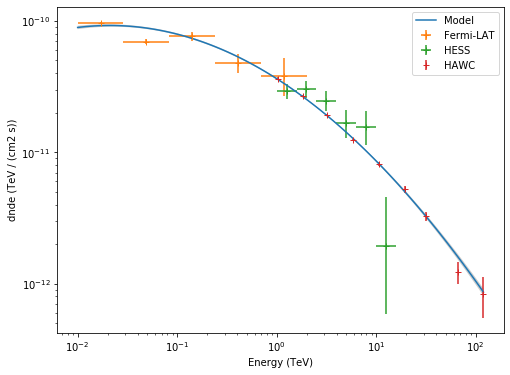

In [10]:
# display spectrum and flux points
energy_range = [0.01, 120] * u.TeV
plt.figure(figsize=(8, 6))
ax = crab_spec.plot(energy_range=energy_range, energy_power=2, label="Model")
crab_spec.plot_error(ax=ax, energy_range=energy_range, energy_power=2)
flux_points_fermi.plot(ax=ax, energy_power=2, label="Fermi-LAT")
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS")
flux_points_hawc.plot(ax=ax, energy_power=2, label="HAWC")
plt.legend();